In [1]:
from cmws.examples.scene_understanding.models import scene_understanding
import matplotlib.pyplot as plt
import math
import numpy as np
import torch

In [2]:
device = "cuda"
num_grid_rows, num_grid_cols, num_primitives, max_num_blocks = 3, 3, 3, 3
shape = [2, 3]

generative_model = scene_understanding.GenerativeModel(num_grid_rows, num_grid_cols, num_primitives, 
                                                       max_num_blocks, im_size=256)

generative_model.primitives[0].color = torch.tensor([1., 0., 0.], device=device)
generative_model.primitives[0].size = torch.tensor(0.3, device=device)
generative_model.primitives[1].color = torch.tensor([0., 1., 0.], device=device)
generative_model.primitives[1].size = torch.tensor(0.4, device=device)
generative_model.primitives[2].color = torch.tensor([0., 0., 1.], device=device)
generative_model.primitives[2].size = torch.tensor(0.5, device=device)

def latent_to_str(latent):
    primitive_id_to_str = {0: "R", 1: "G", 2: "B"}
    num_blocks, stacking_program, raw_locations = latent
    num_grid_rows, num_grid_cols, max_num_blocks = stacking_program.shape
    latent_str = []
    for row in reversed(range(num_grid_rows)):
        tmp = []
        for col in reversed(range(num_grid_cols)):
            s = ["." for _ in range(max_num_blocks)]
            s[:num_blocks[row, col]] = "".join([primitive_id_to_str[x.item()] for x in stacking_program[row, col, :num_blocks[row, col]]])
            tmp.append("".join(s))
        latent_str.append("|".join(tmp))

    return "\n".join(latent_str)


def plot_latent_obs(latent, obs):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(obs.permute(1, 2, 0).detach().cpu())
    ax.text(
        0.95,
        0.95,
        latent_to_str(latent),
        transform=ax.transAxes,
        fontsize=12,
        va="top",
        ha="right",
        color="black",
    )
    plt.show()

RuntimeError: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

In [ ]:
latent, obs = generative_model.sample()
num_blocks, stacking_program, raw_locations = latent

plot_latent_obs(latent, obs)

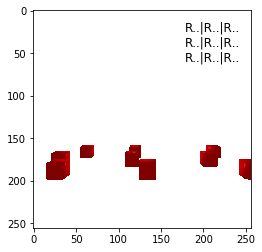

In [4]:
num_blocks = torch.ones(num_grid_rows, num_grid_cols, device=device).long()
stacking_program = torch.zeros(num_grid_rows, num_grid_cols, max_num_blocks, device=device).long()
raw_locations = 10 * torch.randn(num_grid_rows, num_grid_cols, max_num_blocks, device=device)
latent = num_blocks, stacking_program, raw_locations
obs = generative_model.get_obs_loc(latent).detach()

plot_latent_obs(latent, obs)

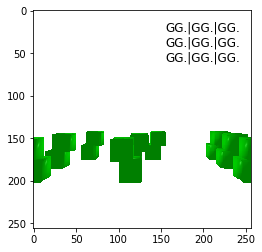

In [5]:
num_blocks = 2 * torch.ones(num_grid_rows, num_grid_cols, device=device).long()
stacking_program = torch.ones(num_grid_rows, num_grid_cols, max_num_blocks, device=device).long()
raw_locations = 10 * torch.randn(num_grid_rows, num_grid_cols, max_num_blocks, device=device)
latent = num_blocks, stacking_program, raw_locations
obs = generative_model.get_obs_loc(latent).detach()

plot_latent_obs(latent, obs)

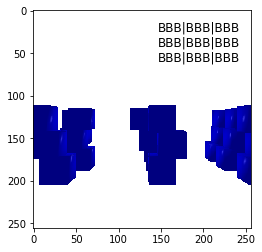

In [54]:
num_blocks = 3 * torch.ones(num_grid_rows, num_grid_cols, device=device).long()
stacking_program = 2 * torch.ones(num_grid_rows, num_grid_cols, max_num_blocks, device=device).long()
raw_locations = 10 * torch.randn(num_grid_rows, num_grid_cols, max_num_blocks, device=device)
latent = num_blocks, stacking_program, raw_locations
obs = generative_model.get_obs_loc(latent).detach()

plot_latent_obs(latent, obs)